# Capstone Project: Multi-Agent Customer Service System

In this capstone, we'll build a complete customer service system that combines everything we've learned:

- **Agents & Tools** (Lesson 1-2)
- **Structured Output & Context** (Lesson 3)
- **Handoffs** (Lesson 4)
- **Agents-as-Tools** (Lesson 5)
- **Guardrails** (Lesson 6)
- **Sessions & Tracing** (Lesson 7)

## System Architecture

```
Customer Message
       │
       ▼
┌──────────────────┐
│   TriageAgent    │──── [Input Guardrail: Block abuse]
│   (Router)       │
└──────────────────┘
       │ handoff
       ├─────────────────────┐
       ▼                     ▼
┌──────────────────┐  ┌──────────────────┐
│  OrderAgent      │  │  RefundAgent     │
│  - lookup_order  │  │  - calc_refund   │
│  - track_status  │  │  - process_refund│
└──────────────────┘  └──────────────────┘
       │                     │
       └─────────────────────┘
                 │
                 ▼
        [Session Memory]
        [Tracing → Dashboard]
```

## Setup

In [1]:
import nest_asyncio
nest_asyncio.apply()

import os
import getpass

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

## Step 1: Define the Data Models

First, let's set up the mock data and Pydantic models for structured output.

In [2]:
from pydantic import BaseModel, Field
from dataclasses import dataclass
from typing import Optional
from datetime import datetime, timedelta

# Mock order database
ORDERS_DB = {
    "ORD-001": {
        "customer_id": "CUST-123",
        "item": "Wireless Headphones",
        "price": 79.99,
        "status": "shipped",
        "tracking": "1Z999AA10123456784",
        "eta": (datetime.now() + timedelta(days=2)).strftime("%Y-%m-%d")
    },
    "ORD-002": {
        "customer_id": "CUST-123",
        "item": "Phone Case",
        "price": 19.99,
        "status": "delivered",
        "tracking": "1Z999AA10123456785",
        "delivered_date": (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")
    },
    "ORD-003": {
        "customer_id": "CUST-456",
        "item": "USB Cable",
        "price": 12.99,
        "status": "processing",
        "tracking": None,
        "eta": "Pending shipment"
    }
}

# Mock customer database
CUSTOMERS_DB = {
    "CUST-123": {
        "name": "Alice Johnson",
        "is_premium": True,
        "lifetime_value": 1250.00
    },
    "CUST-456": {
        "name": "Bob Smith",
        "is_premium": False,
        "lifetime_value": 89.99
    }
}

# Structured output models
class OrderStatus(BaseModel):
    """Order status information."""
    order_id: str
    item: str
    status: str
    tracking_number: Optional[str] = None
    eta: Optional[str] = None

class RefundDecision(BaseModel):
    """Refund processing decision."""
    order_id: str
    eligible: bool
    refund_amount: float
    reason: str
    requires_approval: bool = Field(description="True if refund > $50")

# Customer context
@dataclass
class CustomerContext:
    """Context about the current customer."""
    customer_id: str
    customer_name: str
    is_premium: bool

## Step 2: Build the Tools

Create tools that use context and return structured data.

In [3]:
from agents import function_tool, RunContextWrapper

@function_tool
async def lookup_order(wrapper: RunContextWrapper[CustomerContext], order_id: str) -> str:
    """Look up order details by order ID."""
    ctx = wrapper.context
    
    if order_id not in ORDERS_DB:
        return f"Order {order_id} not found."
    
    order = ORDERS_DB[order_id]
    
    # Verify customer owns this order
    if order["customer_id"] != ctx.customer_id:
        return f"Order {order_id} does not belong to your account."
    
    status_info = f"""
Order {order_id}:
- Item: {order['item']}
- Price: ${order['price']:.2f}
- Status: {order['status'].upper()}
- Tracking: {order.get('tracking', 'Not yet available')}
- ETA: {order.get('eta', order.get('delivered_date', 'N/A'))}
"""
    return status_info

@function_tool
async def list_customer_orders(wrapper: RunContextWrapper[CustomerContext]) -> str:
    """List all orders for the current customer."""
    ctx = wrapper.context
    
    customer_orders = [
        f"- {oid}: {o['item']} (${o['price']:.2f}) - {o['status']}"
        for oid, o in ORDERS_DB.items()
        if o["customer_id"] == ctx.customer_id
    ]
    
    if not customer_orders:
        return "No orders found for your account."
    
    return f"Your orders:\n" + "\n".join(customer_orders)

@function_tool
async def calculate_refund(
    wrapper: RunContextWrapper[CustomerContext],
    order_id: str, 
    reason: str
) -> str:
    """Calculate refund eligibility and amount for an order."""
    ctx = wrapper.context
    
    if order_id not in ORDERS_DB:
        return f"Order {order_id} not found."
    
    order = ORDERS_DB[order_id]
    
    if order["customer_id"] != ctx.customer_id:
        return "This order does not belong to your account."
    
    # Refund policy: 
    # - Delivered within 30 days: full refund
    # - Premium customers: always eligible
    # - Processing orders: can cancel with full refund
    
    price = order["price"]
    status = order["status"]
    
    if status == "processing":
        return f"Order {order_id} can be cancelled for a full refund of ${price:.2f}. Reason: {reason}"
    
    if status == "shipped":
        if ctx.is_premium:
            return f"Premium customer: Eligible for full refund of ${price:.2f} upon return. Reason: {reason}"
        return f"Order in transit. Please wait for delivery to request refund. Reason: {reason}"
    
    if status == "delivered":
        requires_approval = price > 50
        approval_note = " (Requires manager approval)" if requires_approval else ""
        return f"Refund eligible: ${price:.2f}{approval_note}. Reason: {reason}"
    
    return f"Unable to process refund for order {order_id}"

@function_tool
async def process_refund(
    wrapper: RunContextWrapper[CustomerContext],
    order_id: str
) -> str:
    """Process an approved refund for an order."""
    ctx = wrapper.context
    
    if order_id not in ORDERS_DB:
        return f"Order {order_id} not found."
    
    order = ORDERS_DB[order_id]
    price = order["price"]
    
    # Simulate refund processing
    return f"""Refund processed successfully!
- Order: {order_id}
- Amount: ${price:.2f}
- Method: Original payment method
- Timeline: 3-5 business days

Thank you for your patience, {ctx.customer_name}!"""

## Step 3: Build the Guardrail

Block abusive or inappropriate customer messages.

In [4]:
from agents import Agent, Runner, InputGuardrail, GuardrailFunctionOutput

class AbuseCheck(BaseModel):
    """Check for abusive content."""
    is_abusive: bool
    reason: str

abuse_detector = Agent(
    name="AbuseDetector",
    instructions="""Detect if customer message is abusive or inappropriate:
    - Threats or violence
    - Excessive profanity
    - Personal attacks on staff
    - Discriminatory language
    
    NOTE: Frustrated customers expressing disappointment are NOT abusive.
    Only flag truly inappropriate content.""",
    model="gpt-4.1",
    output_type=AbuseCheck
)

async def abuse_guardrail(ctx, agent, input_data):
    result = await Runner.run(abuse_detector, input_data, context=ctx.context)
    check = result.final_output_as(AbuseCheck)
    return GuardrailFunctionOutput(
        output_info=check,
        tripwire_triggered=check.is_abusive
    )

## Step 4: Build the Specialist Agents

Create specialized agents for orders and refunds.

In [5]:
order_agent = Agent(
    name="OrderSpecialist",
    instructions="""You help customers with order-related inquiries.
    
    Capabilities:
    - Look up order status and tracking
    - List customer's orders
    - Provide shipping estimates
    
    Be helpful and provide clear, concise information.
    If a customer wants a refund, let them know you'll transfer them to refunds.""",
    model="gpt-4.1",
    tools=[lookup_order, list_customer_orders],
    handoff_description="Handle order status, tracking, and shipping inquiries"
)

refund_agent = Agent(
    name="RefundSpecialist",
    instructions="""You help customers with refunds and returns.
    
    Process:
    1. First calculate refund eligibility using calculate_refund
    2. If eligible, use process_refund to complete it
    3. If requires approval, explain the timeline
    
    Be empathetic - customers requesting refunds may be frustrated.
    Always explain the refund policy clearly.""",
    model="gpt-4.1",
    tools=[calculate_refund, process_refund, lookup_order],
    handoff_description="Handle refunds, returns, and cancellations"
)

## Step 5: Build the Triage Agent

The triage agent routes customers to the right specialist.

In [6]:
triage_agent = Agent(
    name="CustomerServiceTriage",
    instructions="""You are the front desk of customer service.
    
    Your job:
    1. Understand the customer's issue
    2. Hand off to the appropriate specialist:
       - If they ask about orders, tracking, or shipping → hand off to OrderSpecialist
       - If they ask about refunds, returns, or cancellations → hand off to RefundSpecialist
    
    IMPORTANT: Always use the handoff tools to transfer the customer. 
    Do NOT respond to order or refund questions yourself.
    
    If the question doesn't fit either category, help them directly.
    Be professional and empathetic.""",
    model="gpt-4.1",
    handoffs=[order_agent, refund_agent],
    input_guardrails=[
        InputGuardrail(guardrail_function=abuse_guardrail)
    ]
)

## Optional: Alternative design  agents-as-tools instead of handoffs

The main capstone flow above uses **handoffs** from `CustomerServiceTriage` to `OrderSpecialist` and `RefundSpecialist`.

In some applications you may instead prefer to:
- Keep a **single entry-point** agent that always talks to the user
- Have that agent **call specialist agents as tools** and then summarize their structured outputs back to the user

The next cell defines an **alternative triage agent** that uses the existing `order_agent` and `refund_agent` via `Agent.as_tool(...)`, mirroring the pattern used in the demo app.

**Note:** The rest of this notebook continues to use the original `triage_agent` with handoffs. This alternative is provided just as another design option you can experiment with (for example, by swapping it into the `Runner.run(...)` calls below).

In [7]:
# Alternative triage agent that uses specialists as tools instead of handoffs
triage_agent_with_specialists_as_tools = Agent(
    name="CustomerServiceTriageWithTools",
    instructions="""You are the front desk of customer service.

    Your job:
    1. Understand the customer's issue
    2. Call the appropriate specialist tool:
       - If they ask about orders, tracking, or shipping → use the OrderSpecialist tool
       - If they ask about refunds, returns, or cancellations → use the RefundSpecialist tool
    3. Use the structured data returned by the specialist to craft a friendly,
       helpful response to the customer.

    IMPORTANT: Always call a specialist tool for order or refund questions.
    Do NOT answer order or refund questions without calling a tool first.

    If the question doesn't fit either category, help them directly.
    Be professional and empathetic.""",
    model="gpt-4.1",
    tools=[
        order_agent.as_tool(
            tool_name="order_specialist",
            tool_description="Handle order status, tracking, and shipping inquiries",
        ),
        refund_agent.as_tool(
            tool_name="refund_specialist",
            tool_description="Handle refunds, returns, and cancellations",
        ),
    ],
    input_guardrails=[
        InputGuardrail(guardrail_function=abuse_guardrail),
    ],
)

## Step 6: Set Up Session and Tracing

In [8]:
from agents import trace, RunConfig, SQLiteSession

# Create session for customer Alice
alice_session = SQLiteSession(
    session_id="customer_alice_session",
    db_path="customer_service.db"
)

# Customer context
alice_context = CustomerContext(
    customer_id="CUST-123",
    customer_name="Alice Johnson",
    is_premium=True
)

# Run config for tracing
run_config = RunConfig(
    workflow_name="Customer Service",
    trace_include_sensitive_data=True
)

## Step 7: Run the Customer Service System!

In [17]:
import asyncio
from agents import InputGuardrailTripwireTriggered

async def customer_interaction(message: str):
    """Process a customer message through the system."""
    print(f"\n{'='*60}")
    print(f"Customer: {message}")
    print(f"{'='*60}")
    
    try:
        with trace("Customer Service Interaction"):
            result = await Runner.run(
                triage_agent,
                message,
                context=alice_context,
                session=alice_session,
                run_config=run_config
            )
            print(f"\nAgent: {result.final_output}")
    except InputGuardrailTripwireTriggered as e:
        print(f"\n[BLOCKED] We cannot process abusive messages.")
        print(f"Please contact us respectfully for assistance.")


async def customer_interaction_option2_subagents_as_tools(message: str):
    """Process a customer message through the system."""
    print(f"\n{'='*60}")
    print(f"Customer: {message}")
    print(f"{'='*60}")
    
    try:
        with trace("Customer Service Interaction"):
            result = await Runner.run(
                triage_agent_with_specialists_as_tools,
                message,
                context=alice_context,
                session=alice_session,
                run_config=run_config
            )
            print(f"\nAgent: {result.final_output}")
    except InputGuardrailTripwireTriggered as e:
        print(f"\n[BLOCKED] We cannot process abusive messages.")
        print(f"Please contact us respectfully for assistance.")        

In [10]:
# Conversation 1: Order inquiry
asyncio.run(customer_interaction(
    "Hi, I'd like to check on my order ORD-001. When will it arrive?"
))


Customer: Hi, I'd like to check on my order ORD-001. When will it arrive?

Agent: Your order (ORD-001) for Wireless Headphones has been shipped. The estimated delivery date is February 19, 2026.

If you'd like tracking details or further updates, let me know!


In [11]:
# Conversation 2: Follow-up (session remembers context)
asyncio.run(customer_interaction(
    "What about my other orders?"
))


Customer: What about my other orders?

Agent: Here are your recent orders:
- ORD-001: Wireless Headphones ($79.99) – Shipped, arriving by February 19, 2026.
- ORD-002: Phone Case ($19.99) – Delivered.

If you need more details on any order or want tracking info, just let me know!


In [12]:
# Conversation 3: Refund request
asyncio.run(customer_interaction(
    "I'd like a refund for the phone case, it doesn't fit my phone."
))


Customer: I'd like a refund for the phone case, it doesn't fit my phone.

Agent: Your refund for the phone case (ORD-002) is approved since it doesn’t fit your phone. I have processed the refund in the amount of $19.99, and the money will be returned to your original payment method within 3-5 business days.

Our refund policy allows returns and refunds when items do not fit or are not as described. If you have the product packaging, please return the item as soon as you can, following any provided return instructions.

If you have any other questions or concerns, just let me know—I’m here to help!


In [13]:
# Conversation 4: Test guardrail (this should be blocked)
asyncio.run(customer_interaction(
    "I hate your company! I'm going to destroy you all!"
))


Customer: I hate your company! I'm going to destroy you all!

[BLOCKED] We cannot process abusive messages.
Please contact us respectfully for assistance.


In [14]:
# Conversation 5: Frustrated but not abusive (should work)
asyncio.run(customer_interaction(
    "This is really frustrating. I've been waiting forever for my order!"
))


Customer: This is really frustrating. I've been waiting forever for my order!

Agent: I'm truly sorry to hear that you're frustrated and have had to wait so long for your order. I understand how important it is to receive your items on time, and delays can be really disappointing.

Your feedback matters to us, and I want to make sure your concerns are taken care of as quickly as possible. If you’d like more details or help with your shipment, I can connect you with our Order Specialist for further assistance.

If there's anything else I can do to help or if you have specific concerns, please let me know. Your experience matters to us, and we want to make it right.


In [19]:
asyncio.run(customer_interaction_option2_subagents_as_tools("when will my order arrive? ORD-001"))


Customer: when will my order arrive? ORD-001

Agent: Your order (ORD-001) for Wireless Headphones has already been shipped. The estimated delivery date is February 19, 2026.

If you’d like to track your shipment or need more details, just let me know! I’m here to help.


## Visualize the System

In [15]:
from agents.extensions.visualization import draw_graph
try:
    draw_graph(triage_agent)
except ImportError:
    print("Install visualization: pip install openai-agents[viz]")

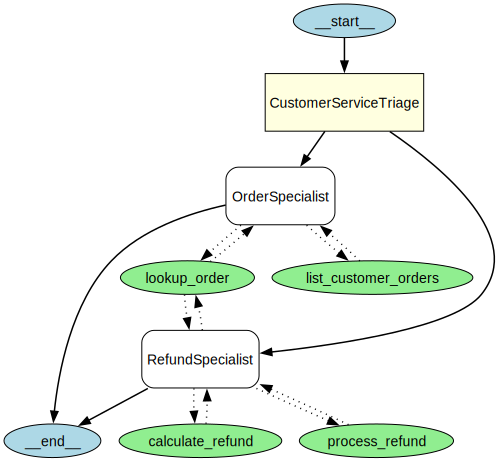

In [16]:
draw_graph(triage_agent)

## Summary: What We Built

This capstone system demonstrates:

| Concept | Implementation |
|---------|----------------|
| **Agents & Tools** | OrderSpecialist and RefundSpecialist with custom tools |
| **Structured Output** | OrderStatus, RefundDecision, AbuseCheck models |
| **Context** | CustomerContext with customer_id, name, is_premium |
| **Handoffs** | TriageAgent routes to specialists |
| **Guardrails** | AbuseDetector blocks inappropriate messages |
| **Sessions** | SQLiteSession maintains conversation history |
| **Tracing** | trace() wrapper with RunConfig for observability |

## Next Steps

To extend this system, you could:

1. **Add more specialists** - Billing agent, technical support, etc.
2. **Real database** - Connect to actual order/customer databases
3. **Human approval workflow** - Manager approval for large refunds
4. **Analytics** - Track resolution rates, handoff patterns
5. **MCP integration** - Connect to CRM or ticketing systems

## View Traces

All interactions are traced and available at:
**https://platform.openai.com/traces**

## Congratulations!

You've completed the OpenAI Agents SDK course! You now know how to:

1. Build agents with custom tools
2. Use structured output for type-safe responses
3. Inject context into tools without exposing it to the LLM
4. Orchestrate multi-agent systems with handoffs and agents-as-tools
5. Add guardrails for input/output validation
6. Persist conversations with sessions
7. Debug and monitor with tracing

Go build something amazing!